<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/MultimodelGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/openai/CLIP.git

!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 168 (delta 36), reused 56 (delta 29), pack-reused 91
Receiving objects: 100% (168/168), 8.92 MiB | 1.44 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 1061 (delta 12), reused 230 (delta 6), pack-reused 810
Receiving objects: 100% (1061/1061), 350.33 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [ ]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

In [ ]:
import numpy as np
import torch, os, imageio, pdb, math
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt
from PIL import Image

import yaml
from omegaconf import OmegaConf

from CLIP import clip

In [ ]:
def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(12, 8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [ ]:
def norm_data(data):
  return (data.clip(-1, 1)+1)/2

In [52]:
lr = .5
batch_size = 1
wd = .1
noise_factor = .1

total_iter = 600
im_shape = [225, 400, 3]
size1, size2, channels = im_shape

In [ ]:
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())
print('Clip model visual input resolution: ', clipmodel.visual.input_resolution)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
Clip model visual input resolution:  224


In [ ]:
%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

/content/taming-transformers/taming-transformers
--2021-10-28 13:57:48--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/15d50310-892c-4dae-ab87-a144dda2745b/last.ckpt [following]
--2021-10-28 13:57:48--  https://heibox.uni-heidelberg.de/seafhttp/files/15d50310-892c-4dae-ab87-a144dda2745b/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  14.9MB/s    in 62s     

2021-10-28 13:58:50 (15.1 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ 

In [ ]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

In [ ]:
def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location='cpu')['state_dict']
    missing, unexpected = model.load_state_dict(state_dict, strict=False)

  return model.eval()

In [ ]:
def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

In [ ]:
taming_config = load_config('./models/vqgan_imagenet_f16_16384/configs/model.yaml', display=True)
taming_model = load_vqgan(taming_config, chk_path='./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt').to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


8.19kB [00:00, 778kB/s]                    

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
class Parameters(nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).to(device)
    self.data = nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

In [ ]:
def init_params():
  params = Parameters().to(device)
  optimizer = optim.AdamW([{'params':[params.data], 'lr':lr}], weight_decay=wd)
  return params, optimizer

In [ ]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encode_text(text):
  t = clip.tokenize(text).to(device)
  t = clipmodel.encode_text(t).detach().clone()
  return t

In [ ]:
def create_encoding(include, exclude, extras):
  include_enc = []
  for text in include:
    include_enc.append(encode_text(text))
  
  exclude_enc = encode_text(exclude)if exclude != '' else 0
  extras_enc = encode_text(extras) if extras != '' else 0

  return include_enc, exclude_enc, extras_enc

torch.Size([1, 256, 14, 25])
Image dimensions:  torch.Size([1, 3, 224, 400])


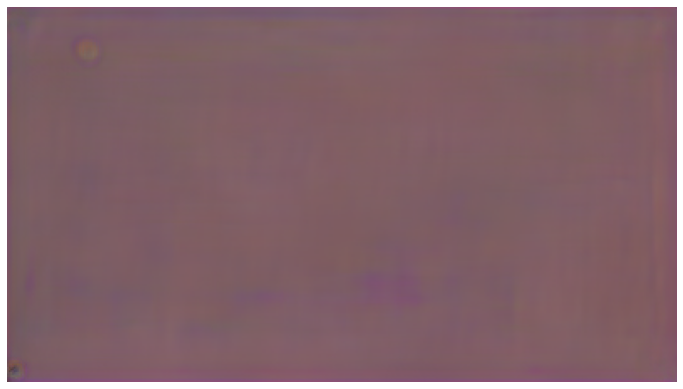

In [ ]:
aug_transform = nn.Sequential(transforms.RandomHorizontalFlip(),
                              transforms.RandomAffine(30, (.2, .2), fill=0)).to(device)

params, optimizer = init_params()

with torch.no_grad():
  print(params().shape)
  img = norm_data(generator(params()).cpu())
  print('Image dimensions: ',img.shape)
  show_from_tensor(img[0])

In [ ]:
def create_crops(img, num_crops=30):
  p = size1//2
  img = nn.functional.pad(img, (p, p, p, p), mode='constant', value=0)

  img = aug_transform(img)

  crop_set = []
  for ch in range(num_crops):
    gap1, gap2 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5)*size1), int(torch.normal(1.0, .5, ()).clip(.2, 1.5)*size1)
    offsetx = torch.randint(0, int(size1*2-gap1), ())
    offsety = torch.randint(0, int(size1*2-gap1), ())

    crop = img[:, :, offsetx:offsetx+gap2, offsety:offsety+gap2]

    crop = nn.functional.interpolate(crop, (224, 224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops = torch.cat(crop_set, 0)

  img_crops = img_crops+noise_factor*torch.randn_like(img_crops, requires_grad=False)

  return img_crops

In [ ]:
def show_me(params, show_crop):
  with torch.no_grad():
    generated = generator(params())

    if show_crop:
      print('Augmented cropped example')
      aug_gen = generated.float()
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print('Generation')
    lastest_gen = norm_data(generated.cpu())
    show_from_tensor(lastest_gen[0])

  return (lastest_gen[0])

In [ ]:
def optimize_result(params, prompt):
  alpha = 1
  beta = .5

  out = generator(params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out)
  image_enc = clipmodel.encode_image(out)

  final_enc = w1*prompt + w1*extras_enc
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True)
  final_text_exclude_enc = exclude_enc

  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1)
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1)

  final_loss = -alpha*main_loss + beta*penalize_loss
  return final_loss

def optimize(params, optimizer, prompt):
  loss = optimize_result(params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def training_loop(params, optimizer, show_crop=False):
  res_img = []
  res_z = []

  for prompt in include_enc:
    iteration = 0
    params, optimizer = init_params()

    for it in range(total_iter):
      loss = optimize(params, optimizer, prompt)

      if iteration > 0 and iteration%(total_iter-1) == 0:
        new_img = show_me(params, show_crop)
        res_img.append(new_img)
        res_z.append(params())
        print('Loss: ', loss.item(), '\niteration: ', iteration)

      iteration +=1
    torch.cuda.empty_cache()
  return res_img, res_z

Augmented cropped example


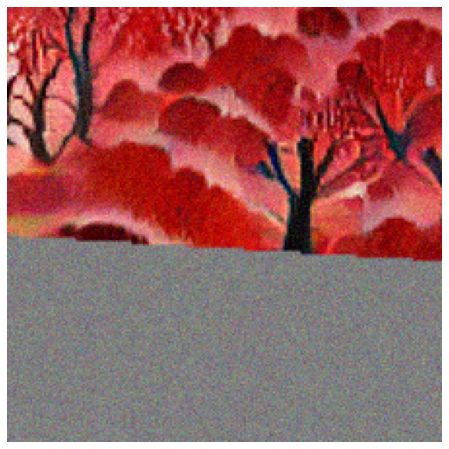

Generation


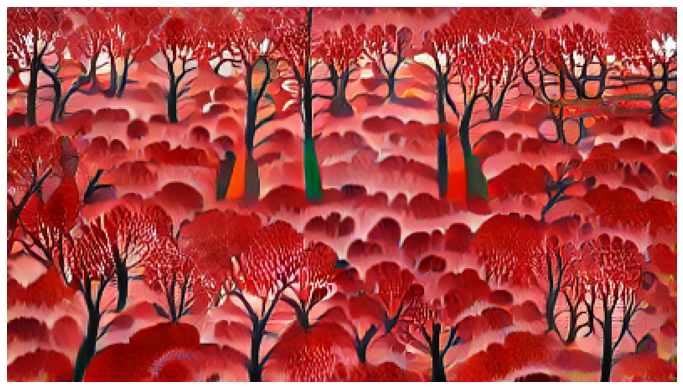

Loss:  -0.2147216796875 
iteration:  599
Augmented cropped example


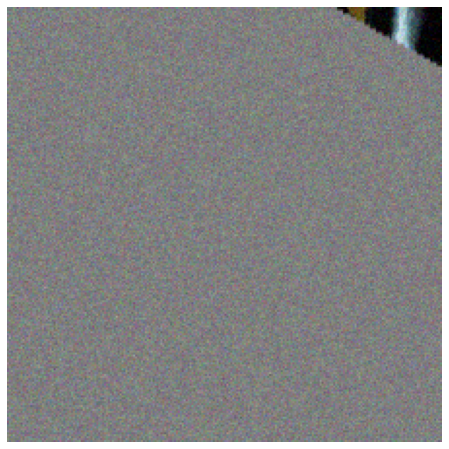

Generation


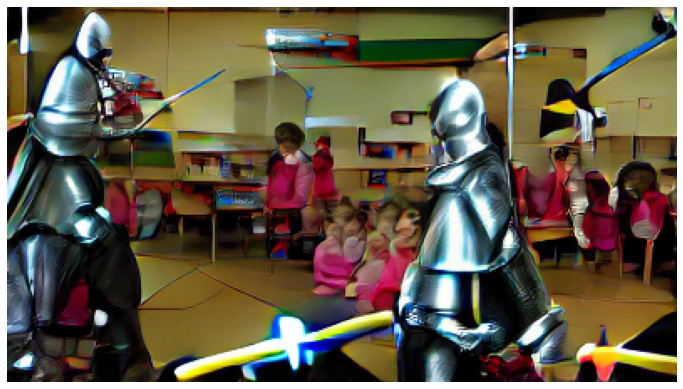

Loss:  -0.1746826171875 
iteration:  599
Augmented cropped example


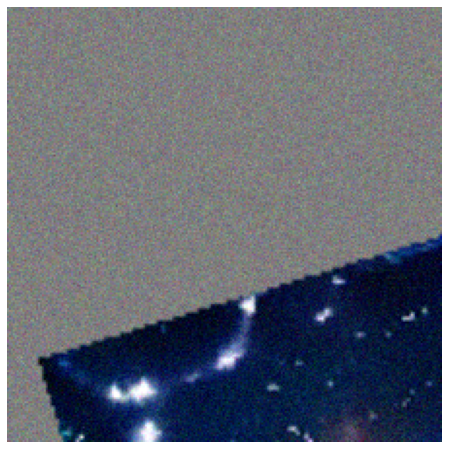

Generation


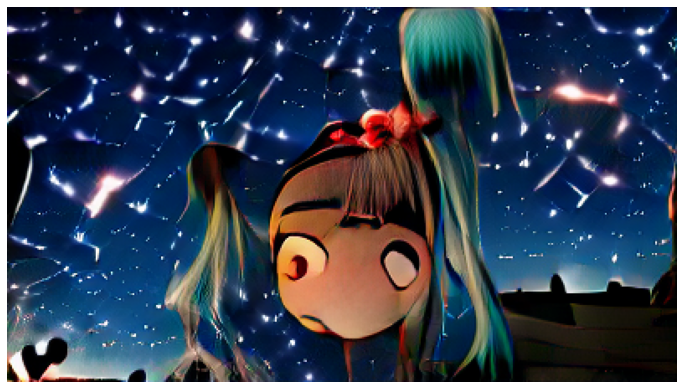

Loss:  -0.2293701171875 
iteration:  599


In [53]:
torch.cuda.empty_cache()
include = ['a forest with red trees', 'a knight using two swords', 'anime girl looking at the stars']
exclude = 'watermark'
extras = ''
w1 = 1
w2 = 1

include_enc, exclude_enc, extras_enc = create_encoding(include, exclude, extras)
res_img, res_z = training_loop(params, optimizer, show_crop=True)

In [ ]:
def interpolate(res_z_list, duration_list):
  gen_img_list = []
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1 = z
    z2 = res_z_list[(idx+1)%len(res_z_list)]

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha*z2+(1-alpha)*z1

      new_gen = norm_data(generator(z_new).cpu())[0]
      new_img = transforms.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)
  
  return gen_img_list

In [ ]:
durations = [3,3,3,3,3,3]
interp_result_img_list = interpolate(res_z, durations)

In [ ]:
out_video_path = f'../res1.mp4'
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

In [ ]:
mp4 = open('../res1.mp4', 'rb').read()
data = 'data:video/mp4;base64,'+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" %data)